# Plotting PyPSA results (adapted for the First Run of Bolivia - config.yaml file)

### Adele will check for additional results that can be used


In [1]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

This is the repository path:  c:\Users\Lenovo\Desktop\pypsa-earth
Had to go 1 folder(s) up.


In [2]:
# utility function for nice plotting


def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

# Load all networks

In [3]:
# add_electricity_network = os.getcwd() + '/networks/elec.nc'
# n_add_el = pypsa.Network(add_electricity_network)

# clustered_network = os.getcwd() + '/networks/elec_s_20.nc'
# n_cluster = pypsa.Network(clustered_network)



#Se carga el documento (o la direccion/path del mismo) a una variable (solved_network)

solved_network = os.getcwd() + "/results/networks/elec_s_10_ec_lcopt_Co2L-6H.nc"

#Se cargan los resultados de la optimizacion del problema segun las caracteristicas definidas para el modelo en n_solve con la funcion (operador?) Network de pypsa

n_solve = pypsa.Network(solved_network)

INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_Co2L-6H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


# Solved network

In [4]:
n = n_solve

In [5]:
# ".global_constraints" muestra las restricciones consideradas para el modelo (en el config.yaml solo se tomo en cuenta el limite de emisiones) tonCO2/year

n.global_constraints

,sense,constant,mu,type,investment_period,carrier_attribute
GlobalConstraint,,,,,,
CO2Limit,<=,77500000.0,2.626656e-14,primary_energy,NaN,co2_emissions


In [6]:
#Calculo del precio promedio de energia promedio en la red (costo total de operacion)= ".objective" /  (sumatoria de las cargas variables en el tiempo)
# EURO/MWh

##### check why the value does not appear


n.objective

486331289.97292686

### Spatial temporal resolution

(<matplotlib.collections.PatchCollection at 0x16605cfb370>,
 <matplotlib.collections.LineCollection at 0x16605dc6680>)

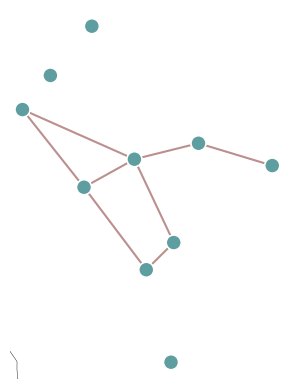

In [7]:
#Resultado grafico de la red electrica ideal (lineas verdes representan expansiones de la red)

#####beacuase all buses are not connected it might be that the problem is not fully solved


n.plot()

In [8]:
#Se muestra el tamaño de la resolucion temporal del modelo - timesteps

len(n.snapshots)

624

### Overview components

In [9]:
#Imprimir la lista de componentes considerados en el dataframe creado

for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name, len(c.df)))

Component 'Bus' has 30 entries
Component 'Carrier' has 16 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 8 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 40 entries
Component 'Load' has 10 entries
Component 'Generator' has 39 entries
Component 'StorageUnit' has 2 entries
Component 'Store' has 20 entries


### Energy balance

In [10]:
# ".stores_t" hace referencia a la energia que se puede almacenar en un bus (se usa para definir otras tecnologias como storage)
#https://pypsa.readthedocs.io/en/latest/components.html#store

n.stores_t.p.sum()

Store
BO 0 H2        -6.352747e-22
BO 1 H2         6.352747e-22
BO 2 H2         2.329341e-21
BO 3 H2         1.694066e-21
BO 4 H2         9.094947e-13
BO 5 H2        -1.058791e-22
BO 6 H2         2.541099e-21
BO 7 H2        -5.684342e-14
BO 8 H2         1.136868e-13
BO 9 H2        -2.117582e-22
BO 0 battery    2.249931e-22
BO 1 battery    1.389663e-22
BO 2 battery   -4.632211e-23
BO 3 battery    9.264423e-23
BO 4 battery   -1.958764e-21
BO 5 battery   -7.279189e-23
BO 6 battery    0.000000e+00
BO 7 battery    5.293956e-23
BO 8 battery   -2.435220e-21
BO 9 battery   -1.786710e-22
dtype: float64

In [11]:
# se imprimen todos los generadores considerados en el modelo

##### check if loadshedding is being used in the config.yaml file, at the solving section


n.generators

print(type(n.generators))
print(n.generators.columns)
n.generators

<class 'pandas.core.frame.DataFrame'>
Index(['p_nom_max', 'weight', 'p_nom', 'capital_cost', 'efficiency',
       'p_nom_min', 'marginal_cost', 'p_nom_extendable', 'bus', 'carrier',
       'control', 'p_nom_opt', 'sign', 'build_year', 'min_up_time',
       'min_down_time', 'up_time_before', 'down_time_before', 'type',
       'p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'lifetime', 'committable',
       'start_up_cost', 'shut_down_cost', 'ramp_limit_up', 'ramp_limit_down',
       'ramp_limit_start_up', 'ramp_limit_shut_down'],
      dtype='object')


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,bus,carrier,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 OCGT,inf,0.000000,3.535638e+02,47234.561404,0.390,353.563766,58.394908,True,BO 0,OCGT,Slack,3.535638e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 onwind,5.872036e+05,59888.246048,1.218925e+01,109295.569252,1.000,12.189249,0.024520,True,BO 0,onwind,,1.218925e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 solar,2.221573e+05,30992.064349,1.126932e+01,50855.958267,1.000,11.269319,0.019875,True,BO 0,solar,,1.126932e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 OCGT,inf,0.000000,7.224879e+01,47234.561404,0.390,72.248791,58.395317,True,BO 1,OCGT,,7.224879e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 onwind,1.288879e+05,1351.910844,2.186493e-01,109295.569252,1.000,0.218649,0.025178,True,BO 1,onwind,,2.186490e-01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 ror,inf,260.721486,2.607215e+02,270940.715283,0.900,0.000000,0.009765,False,BO 1,ror,,2.607215e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 solar,1.612263e+05,30267.135767,1.090383e+01,50855.958267,1.000,10.903831,0.020678,True,BO 1,solar,,1.090383e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 OCGT,inf,0.000000,1.078072e+02,47234.561404,0.390,107.807199,58.394822,True,BO 2,OCGT,,1.078072e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 oil,inf,0.000000,3.399651e+01,38234.561404,0.393,33.996513,130.236109,False,BO 2,oil,,3.399651e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [12]:
#Imprimir solo los generadores de Bolivia

########(check load sheeding to see if load is a problem)

idx = ['BO' in x for x in n.generators.index]
n.generators.loc[idx,:]

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,bus,carrier,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 OCGT,inf,0.000000,3.535638e+02,47234.561404,0.390,353.563766,58.394908,True,BO 0,OCGT,Slack,3.535638e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 onwind,5.872036e+05,59888.246048,1.218925e+01,109295.569252,1.000,12.189249,0.024520,True,BO 0,onwind,,1.218925e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 solar,2.221573e+05,30992.064349,1.126932e+01,50855.958267,1.000,11.269319,0.019875,True,BO 0,solar,,1.126932e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 OCGT,inf,0.000000,7.224879e+01,47234.561404,0.390,72.248791,58.395317,True,BO 1,OCGT,,7.224879e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 onwind,1.288879e+05,1351.910844,2.186493e-01,109295.569252,1.000,0.218649,0.025178,True,BO 1,onwind,,2.186490e-01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 ror,inf,260.721486,2.607215e+02,270940.715283,0.900,0.000000,0.009765,False,BO 1,ror,,2.607215e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 solar,1.612263e+05,30267.135767,1.090383e+01,50855.958267,1.000,10.903831,0.020678,True,BO 1,solar,,1.090383e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 OCGT,inf,0.000000,1.078072e+02,47234.561404,0.390,107.807199,58.394822,True,BO 2,OCGT,,1.078072e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 oil,inf,0.000000,3.399651e+01,38234.561404,0.393,33.996513,130.236109,False,BO 2,oil,,3.399651e+01,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [13]:
#Imprimir la suma de potencias nominales (2013) de los generadores de Bolivia

idx = ['BO' in x for x in n.generators.index]
n.generators.loc[idx,:].p_nom.sum()

10000001437.498108

In [14]:
# Difference between total load and generation
# losses = n.stores_t

n.generators_t.p.sum().sum() - n.loads_t.p.sum().sum()  # - substract storage losses


131243.25102662866

### Total installed generator capacity

In [15]:
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8744\2958603594.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen_cap = n.generators.groupby(["carrier"]).sum()


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,
OCGT,NaN,0.000000,9.143409e+02,2.834074e+05,2.340,914.340881,350.368475,6,9.143409e+02,6.00,0,0,0,6,0,0.0,6.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,6.0,6.0
load,NaN,0.000000,1.000000e+10,0.000000e+00,10.000,0.000000,10.103516,0,1.000000e+10,0.01,0,0,0,10,0,0.0,10.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,10.0,10.0
oil,inf,0.000000,3.399651e+01,3.823456e+04,0.393,33.996513,130.236109,0,3.399651e+01,1.00,0,0,0,1,0,0.0,1.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,1.0,1.0
onwind,2.376047e+06,124486.370505,2.596471e+01,1.092956e+06,10.000,25.964709,0.249816,10,2.596471e+01,10.00,0,0,0,10,0,0.0,10.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,10.0,10.0
ror,NaN,344.006279,3.440063e+02,5.418814e+05,1.800,0.000000,0.018835,0,3.440063e+02,2.00,0,0,0,2,0,0.0,2.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,2.0,2.0
solar,1.869632e+06,324318.258522,1.191897e+02,5.085596e+05,10.000,119.189726,0.202055,10,5.256935e+03,10.00,0,0,0,10,0,0.0,10.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,10.0,10.0


In [16]:
n.stores_t.p.head()

Store,BO 0 H2,BO 1 H2,BO 2 H2,BO 3 H2,BO 4 H2,BO 5 H2,BO 6 H2,BO 7 H2,BO 8 H2,BO 9 H2,BO 0 battery,BO 1 battery,BO 2 battery,BO 3 battery,BO 4 battery,BO 5 battery,BO 6 battery,BO 7 battery,BO 8 battery,BO 9 battery
snapshot,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,1.172245e-07,1.168223e-07,1.162347e-07,1.168766e-07,399.338824,1.170078e-07,1.168324e-07,4.808383,48.316710,1.166180e-07,9.481639e-10,9.841524e-10,9.682410e-10,9.768492e-10,2.612063e-07,9.702111e-10,9.696118e-10,1.128700e-07,7.302105e-09,9.532125e-10
2013-01-01 06:00:00,1.212493e-07,1.210521e-07,1.208752e-07,1.210824e-07,341.472459,1.211174e-07,1.211398e-07,4.111431,41.313429,1.209804e-07,1.279148e-08,1.275690e-08,1.274695e-08,1.275837e-08,2.623847e-07,1.278984e-08,1.277730e-08,1.157445e-07,1.217944e-08,1.273689e-08
2013-01-01 12:00:00,-4.038109e-07,-4.031145e-07,-4.024117e-07,-4.031377e-07,-546.012733,-4.033854e-07,-4.032177e-07,-5.725980,-67.521702,-4.027331e-07,-2.673949e-08,-2.671374e-08,-2.670561e-08,-2.670721e-08,-5.224428e-07,-2.673787e-08,-2.671556e-08,-2.281706e-07,-3.147180e-09,-2.671647e-08
2013-01-01 18:00:00,8.680491e-08,8.678822e-08,8.705760e-08,8.683001e-08,-388.948629,8.674159e-08,8.699561e-08,-2.303467,-47.113670,8.705486e-08,1.288769e-08,1.289600e-08,1.289977e-08,1.289222e-08,-1.149956e-09,1.289312e-08,1.292613e-08,-4.450618e-10,-1.850479e-08,1.291325e-08
2013-01-02 00:00:00,6.818421e-08,6.760715e-08,6.677682e-08,6.769140e-08,404.427361,6.798909e-08,6.758755e-08,4.861396,48.849414,6.713123e-08,4.736741e-10,4.540834e-10,4.278198e-10,4.550880e-10,2.602148e-07,4.671973e-10,4.388052e-10,1.125635e-07,8.088180e-09,4.321408e-10


<AxesSubplot:xlabel='snapshot'>

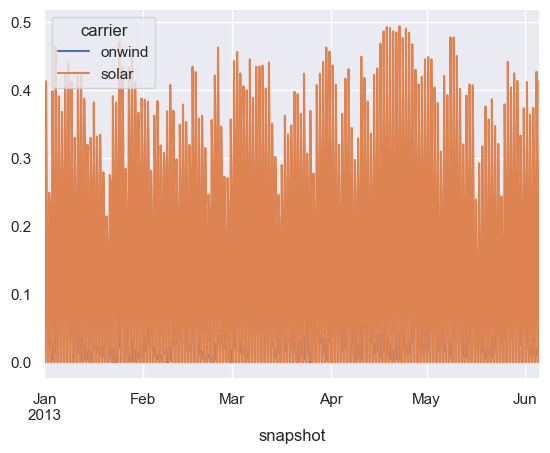

In [17]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot()

In [18]:
# If 0, all renewable capacity potential is used
n.generators.p_nom_max.sum() - n.generators.p_nom_opt.sum()

inf

In [19]:
n.loads_t.p.sum().sum()

802471.019970253

In [20]:
n.generators_t.p.sum().sum()

933714.2709968816

In [21]:
#### pq la multiplicacion?

n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom.sum() * 0.0000003

bus   carrier
BO 0  OCGT       1.060691e-04
      load       3.000000e+02
      onwind     3.656775e-06
      solar      3.380796e-06
BO 1  OCGT       2.167464e-05
      load       3.000000e+02
      onwind     6.559479e-08
      ror        7.821645e-05
      solar      3.271149e-06
BO 2  OCGT       3.234216e-05
      load       3.000000e+02
      oil        1.019895e-05
      onwind     1.953577e-06
      solar      1.390673e-05
BO 3  OCGT       4.495021e-05
      load       3.000000e+02
      onwind     0.000000e+00
      ror        2.498544e-05
      solar      9.477031e-07
BO 4  load       3.000000e+02
      onwind     1.681481e-06
      solar      5.814411e-06
BO 5  OCGT       6.538507e-05
      load       3.000000e+02
      onwind     1.198242e-07
      solar      3.911166e-07
BO 6  load       3.000000e+02
      onwind     3.121608e-07
      solar      6.799367e-06
BO 7  load       3.000000e+02
      onwind     0.000000e+00
      solar      1.229392e-07
BO 8  load       3.000000e

AssertionError: Colors not defined for all elements in the second MultiIndex level of bus_sizes, please make sure that all the elements are included in bus_colors or in n.carriers.color

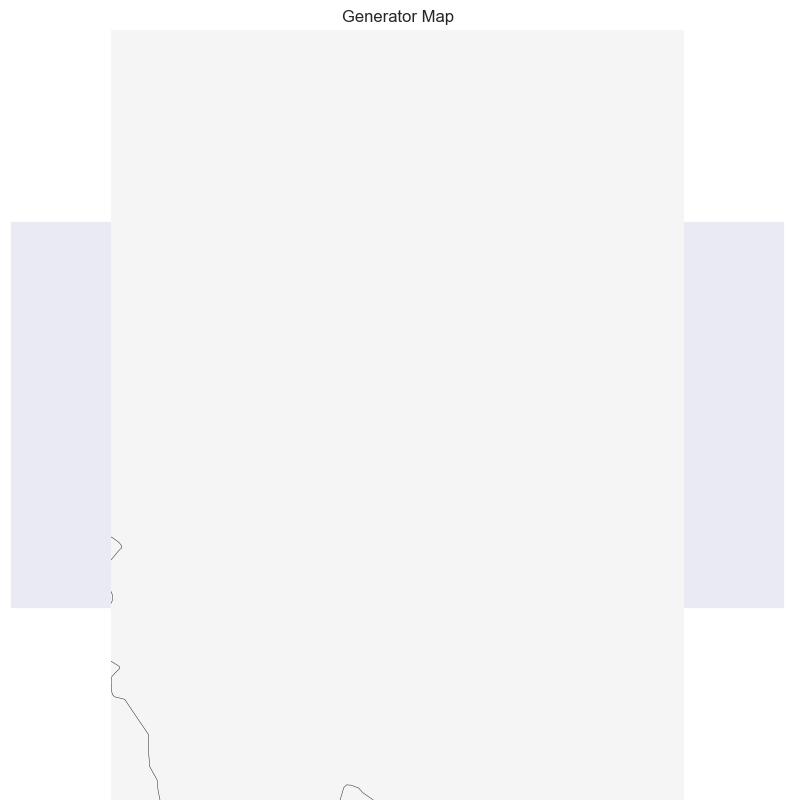

In [39]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

### Demand

In [23]:
print(type(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()))

print(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum())

<class 'pandas.core.series.Series'>
bus
BO 0    1.000000e+09
BO 1    1.000000e+09
BO 2    1.000000e+09
BO 3    1.000000e+09
BO 4    1.000003e+09
BO 5    1.000000e+09
BO 6    1.000002e+09
BO 7    1.000000e+09
BO 8    1.000000e+09
BO 9    1.000000e+09
Name: p_nom_opt, dtype: float64


<AxesSubplot:xlabel='snapshot'>

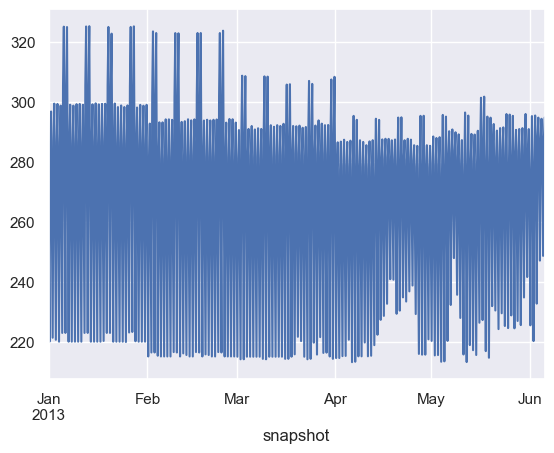

In [26]:
n.loads_t.p_set.loc["2013-01-01":"2013-06-06","BO 0"].plot()

In [27]:
type(n.loads_t.p_set.sum())

pandas.core.series.Series

In [28]:
a = n.loads_t.p_set.sum().rename("load").rename_axis("bus")
a.rename("load", inplace=True)
a.rename_axis("bus", inplace=True)
a

bus
BO 0    165760.688502
BO 1     81159.348527
BO 2    191724.571497
BO 3     66017.013065
BO 4    149443.435993
BO 5     48288.153868
BO 6     73000.693259
BO 7      1794.942286
BO 8     18036.350625
BO 9      7245.822349
Name: load, dtype: float64

In [32]:
n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()

###### potencia maxima?
#n.generators.iloc[:, :].groupby(["bus"]).p_max_pu.sum()

bus
BO 0    1.000000e+09
BO 1    1.000000e+09
BO 2    1.000000e+09
BO 3    1.000000e+09
BO 4    1.000003e+09
BO 5    1.000000e+09
BO 6    1.000002e+09
BO 7    1.000000e+09
BO 8    1.000000e+09
BO 9    1.000000e+09
Name: p_nom_opt, dtype: float64

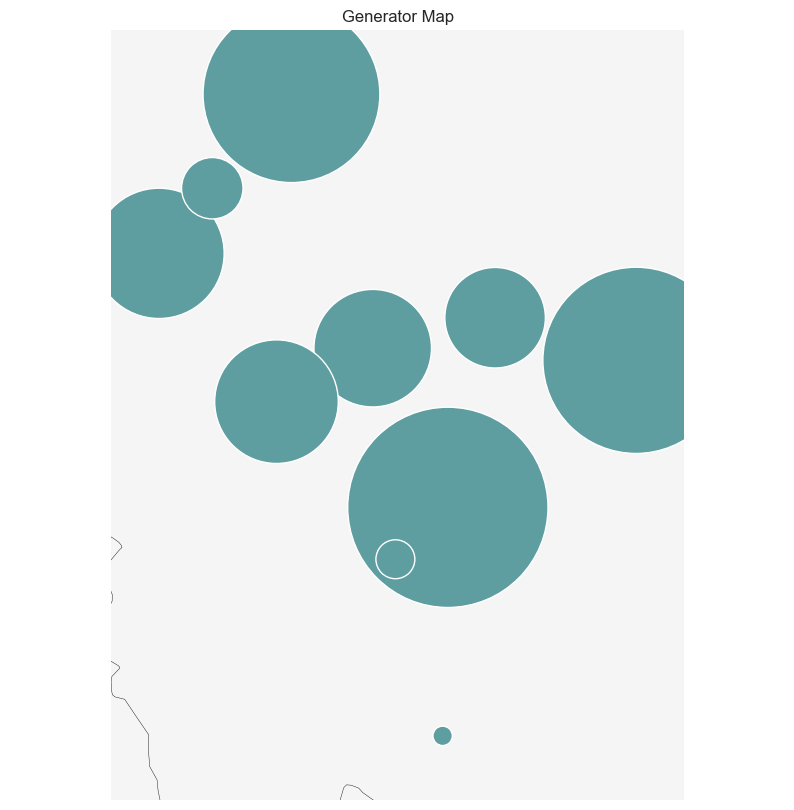

In [33]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3000000000e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

In [34]:
# backup
gen_serie = n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
load_serie = n.loads_t.p_set.sum().rename("load").rename_axis("bus")

load_serie = pd.Series(
    load_serie.values,
    index=pd.MultiIndex.from_tuples([(id, "AC load") for id in load_serie.index]),
)

tot_serie = pd.concat([gen_serie, load_serie])  # .groupby(['bus', 'carrier']).sum()

pd.concat([gen_serie, load_serie])

bus   carrier
BO 0  OCGT       3.535638e+02
      load       1.000000e+09
      onwind     1.218925e+01
      solar      1.126932e+01
BO 1  OCGT       7.224879e+01
      load       1.000000e+09
      onwind     2.186490e-01
      ror        2.607215e+02
      solar      1.090383e+01
BO 2  OCGT       1.078072e+02
      load       1.000000e+09
      oil        3.399651e+01
      onwind     6.511923e+00
      solar      4.635576e+01
BO 3  OCGT       1.498340e+02
      load       1.000000e+09
      onwind     8.243882e-09
      ror        8.328479e+01
      solar      3.159010e+00
BO 4  load       1.000000e+09
      onwind     5.604937e+00
      solar      3.059836e+03
BO 5  OCGT       2.179502e+02
      load       1.000000e+09
      onwind     3.994140e-01
      solar      1.303722e+00
BO 6  load       1.000000e+09
      onwind     1.040536e+00
      solar      1.637150e+03
BO 7  load       1.000000e+09
      onwind     1.218474e-08
      solar      2.688701e+01
BO 8  load       1.000000e

### Plot of Average Marginal Price

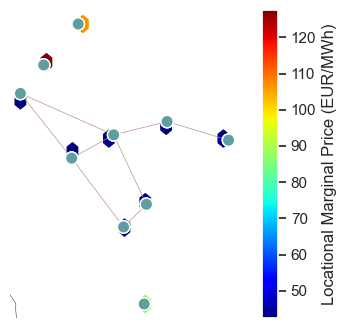

In [35]:
now = n.snapshots[4]  ##one specific time

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(6, 4)

n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index))
plt.hexbin(
    n.buses.x,
    n.buses.y,
    gridsize=20,
    # C=n.buses_t.marginal_price.loc[now], #at one time (previous set up by scigrid)
    C=n.buses_t.marginal_price.sum()
    / len(n.snapshots[:]),  # Marginal price averaged over the whole year (My version)
    # - shows in which regions electricity will be cheap and where el. intensive companies should be placed.
    cmap=plt.cm.jet,
)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label("Locational Marginal Price (EUR/MWh)")

### Storage

<AxesSubplot:xlabel='snapshot'>

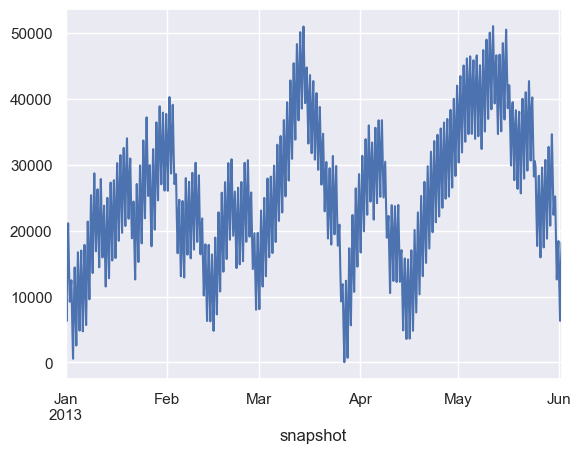

In [36]:
n.stores_t.e.loc["2013-01-01":"2013-06-01"].sum(axis=1).plot()

In [37]:
n.links.iloc[:].groupby(["carrier"]).p_nom_opt.sum()

carrier
H2 electrolysis       779.221808
H2 fuel cell          482.540710
battery charger         0.000004
battery discharger      0.000004
Name: p_nom_opt, dtype: float64